# Chapter 8: Network Analysis

Network data are currently generated and collected to an increasing extent from different fields.
In this notebook we will introduce the basiscs of network analysis. 
We show how network data analysis allows us to gain insight into the data that would be hard to acquire by other means.
We work with concepts such as connected components, centrality measures and ego-networks, as well as community detection.
We use a Python toolbox (NetworkX) to build graphs easily and analyze them.
We deal with real problems dealing with a Facebook network and answering a set of questions. 

In [157]:
import numpy as np
import networkx as nx

In [158]:
import matplotlib.pylab as plt

%matplotlib inline 
plt.style.use('seaborn-whitegrid')
plt.rc('text', usetex = True)
plt.rc('font', family = 'times')
plt.rc('xtick', labelsize = 10) 
plt.rc('ytick', labelsize = 10) 
plt.rc('font', size = 12) 
plt.rc('figure', figsize = (12, 5))


/var/folders/z8/lf08cst56rv_dv3_7mrpfhcm0000gn/T/ipykernel_18992/2682737641.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


## Begining with NetworkX

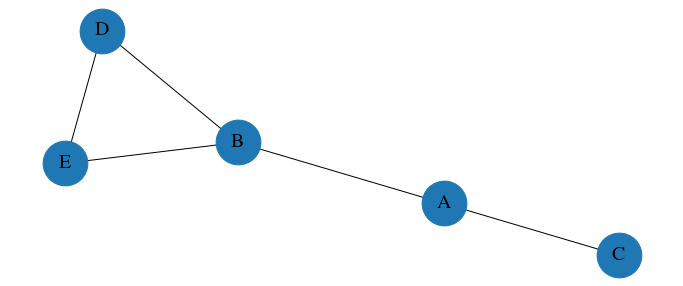

In [159]:
G = nx.Graph()

# Add three edges
G.add_edge('A', 'B');
G.add_edge('A', 'C');
G.add_edge('B', 'D');
G.add_edge('B', 'E');
G.add_edge('D', 'E');

# Draw the graph
nx.draw_networkx(G, node_size = 2000, font_size = 20)

plt.axis('off');
plt.savefig("files/ch08/graph_example.png", dpi = 300, bbox_inches = 'tight')


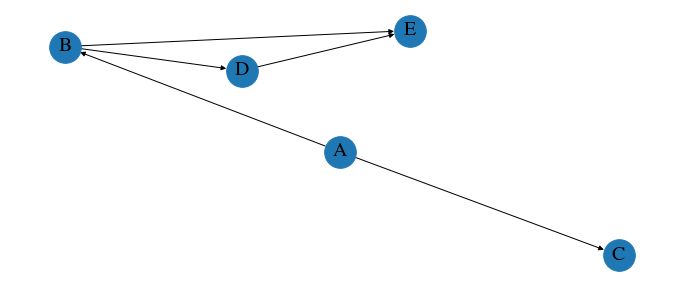

In [160]:
# To create a directed graph we use DiGraph:
G = nx.DiGraph()
G.add_edge('A', 'B');
G.add_edge('A', 'C');
G.add_edge('B', 'D');
G.add_edge('B', 'E');
G.add_edge('D', 'E');
nx.draw_networkx(G, node_size = 1000, font_size = 20)
plt.axis('off');

This example shows an undirected graph with 5 nodes and 5 edges. 
The degree of the node C is 1, the nodes A, E and F is 2 and node B is 3. 
In this example, paths (C, A, B, E), (C, A, B, F, E) are the paths between nodes C and E. 
This graph is unweighted, so the shortest path between C and E is the one crossing less number of edges, which is (C, A, B, E). 
In the example the graph has only one connected component.

We can create another graph, called star graph:

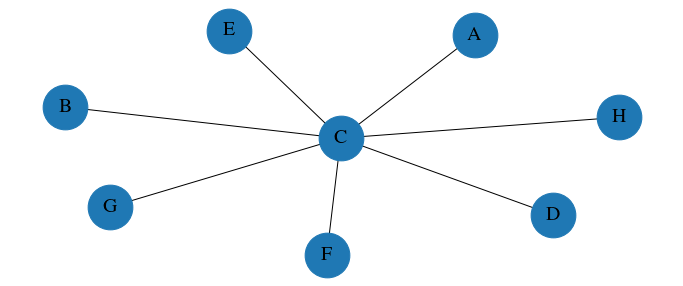

In [161]:
# Create a star graph:
G = nx.Graph()
G.add_edge('A', 'C');
G.add_edge('B', 'C');
G.add_edge('D', 'C');
G.add_edge('E', 'C');
G.add_edge('F', 'C');
G.add_edge('G', 'C');
G.add_edge('H', 'C');

nx.draw_networkx(G, node_size = 2000, font_size = 20)
plt.axis('off')
plt.savefig("files/ch08/star_graph.png", dpi = 300, bbox_inches = 'tight')

## Data description of Facebook Network

We will use data from [SNAP](https://snap.stanford.edu/data/) collection: *Social circles: Facebook* [EGO_FACEBOOK](https://snap.stanford.edu/data/egonets-Facebook.html).
The Facbook dataset consists of a network representing friendship between users of Facebook.
Facebook data was collected from survey participants using a Facebook app.
Facebook data was anonymized by replacing the Facebook internal identifiers for each user with a new value.

Let's load the Facebook network into NetworkX.
The network consists of an undirected and unweighted network that contains friendships between users of Facebook.
The facebook dataset is defined by an edge list, so the file is a plain text file with one edge per line. The file is uncompressed and ready to load as follows.

In [162]:
fb = nx.read_edgelist("files/ch08/facebook_combined.txt")

First, we can extract information from the graph without visualizing it. Basic graph properties include number of nodes, of edges and average degree.

In [163]:
fb_n, fb_k = fb.order(), fb.size()
fb_avg_deg = fb_k / fb_n
print('Nodes: ', fb_n)
print('Edges: ', fb_k)
print('Average degree: ', fb_avg_deg)

Nodes:  4039
Edges:  88234
Average degree:  21.84550631344392


We can also compute the **degree distribution** of the graph and plot it.


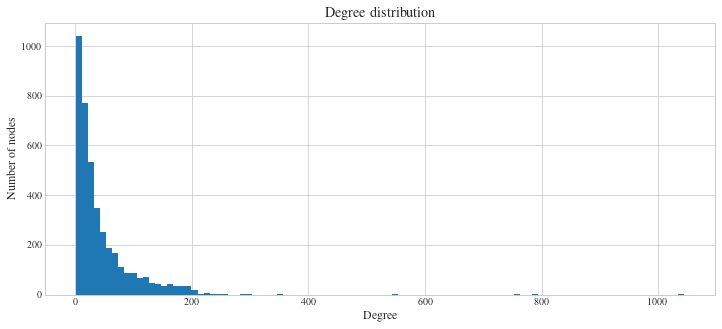

In [164]:
degrees = dict(fb.degree()).values() # degree returns a view object DegreeView  
degree_hist = plt.hist(degrees, 100)
plt.xlabel('Degree')
plt.ylabel('Number of nodes')
plt.title('Degree distribution')
plt.savefig("files/ch08/degree_hist_plt.png", dpi = 300, bbox_inches = 'tight')

Networks with power-law distributions are called *scale-free networks*, because power laws have the same functional form at all scales.

Next, let us find out if the Facebook dataset contains one or more than one connected components.

In [165]:
print('# connected components of Facebook network: ', nx.number_connected_components(fb))

# connected components of Facebook network:  1


Let us prune the graph removing node '0' (arbitrarily selected) and compute the number of connected components of the pruned version of the graph:

In [166]:
fb_prunned = nx.read_edgelist("files/ch08/facebook_combined.txt")
fb_prunned.remove_node('0')
print('Remaining nodes:', fb_prunned.number_of_nodes())
print('New # connected components:', nx.number_connected_components(fb_prunned))

Remaining nodes: 4038
New # connected components: 19


Let us see the sizes of the 19 connected components:

In [167]:
fb_components = nx.connected_components(fb_prunned)
print('Sizes of the connected components', [len(c) for c in fb_components])

Sizes of the connected components [4015, 1, 1, 1, 1, 2, 1, 1, 1, 3, 1, 1, 1, 1, 2, 2, 1, 1, 1]


## Centrality

**Centrality** of a node **measures its relative importance** within the graph. And there are many ways of calculating centrality, each one with a slightly different meaning.
Four of these measures are: 
- The degree centrality
- The betweenness centrality
- The closeness centrality
- The eigenvector centrality

Let's compute the centrality of the nodes in the star graph, G, defined above.

In [168]:
# Centrality measures for the star graph:
degree = nx.degree_centrality(G)
betweenness = nx.betweenness_centrality(G)
print('Degree centrality: ', sorted(degree.items(), key = lambda x: x[1], reverse = True))
print('Betweenness centrality: ', sorted(betweenness.items(), key = lambda x: x[1], reverse = True))

Degree centrality:  [('C', 1.0), ('A', 0.14285714285714285), ('B', 0.14285714285714285), ('D', 0.14285714285714285), ('E', 0.14285714285714285), ('F', 0.14285714285714285), ('G', 0.14285714285714285), ('H', 0.14285714285714285)]
Betweenness centrality:  [('C', 1.0), ('A', 0.0), ('B', 0.0), ('D', 0.0), ('E', 0.0), ('F', 0.0), ('G', 0.0), ('H', 0.0)]


As it can be seen, even if the order of nodes following the two centrality measures is the same, the measure values are different.

 Let us compute the degree centrality of facebook graph.

In [169]:
degree_cent_fb = nx.degree_centrality(fb)
# Once we are calculated degree centrality, we sort the results to see which nodes are more central.
print('Facebook degree centrality: ', sorted(degree_cent_fb.items(), key = lambda x: x[1], reverse = True)[:10])

Facebook degree centrality:  [('107', 0.258791480931154), ('1684', 0.1961367013372957), ('1912', 0.18697374938088163), ('3437', 0.13546310054482416), ('0', 0.08593363051015354), ('2543', 0.07280832095096582), ('2347', 0.07206537890044576), ('1888', 0.0629024269440317), ('1800', 0.06067360079247152), ('1663', 0.058197127290737984)]


Now, let us compute the degree centrality histogram.

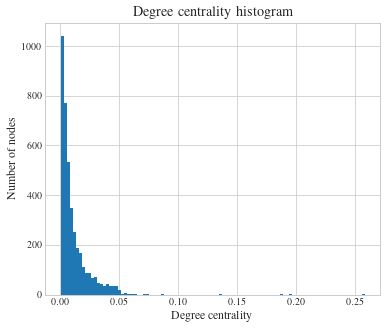

In [170]:
fig = plt.figure(figsize = (6,5))

degree_hist = plt.hist(list(degree_cent_fb.values()), 100)
plt.xlabel('Degree centrality')
plt.ylabel('Number of nodes')
plt.title('Degree centrality histogram')
plt.savefig("files/ch08/degree_centrality_hist.png", dpi = 300, bbox_inches = 'tight')

Let us compute the degree histogram and plot it using logaithmic scale.

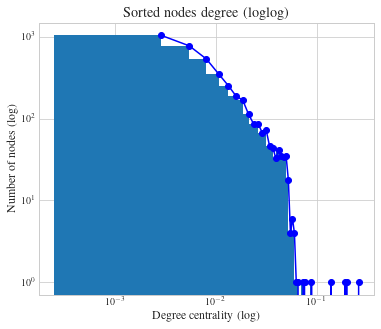

In [171]:
fig = plt.figure(figsize = (6,5))
degree_hist = plt.hist(list(degree_cent_fb.values()), 100)
plt.loglog(degree_hist[1][1:], degree_hist[0], 'b', marker = 'o')
plt.ylabel('Number of nodes (log)')
plt.xlabel('Degree centrality (log)')
plt.title('Sorted nodes degree (loglog)')
plt.savefig("files/ch08/degree_centrality_hist_log.png", dpi = 300, bbox_inches = 'tight')

There is an interesting (large) cluster which corresponds to low degrees. The representation using a logarithmic scale  is useful to distinguish the members of this cluster, which are clearly visible as a straight line at lower x-axis values (upper left-hand part).
We can conclude that most of the nodes in the graph have low degree centrality; only a few of them have high degree centrality. These latter nodes can be properly seen as the points in the bottom right-hand part of the logarithmic plot.


Let's compute the other centrality measures: betweenness, closeness and eigenvector. We sort the results to see which nodes are more central.


In [172]:
betweenness_fb = nx.betweenness_centrality(fb)
closeness_fb = nx.closeness_centrality(fb)
eigencentrality_fb = nx.eigenvector_centrality(fb)
print('Facebook betweenness centrality:', sorted(betweenness_fb.items(), key = lambda x: x[1], reverse = True)[:10])
print('Facebook closeness centrality:', sorted(closeness_fb.items(), key = lambda x: x[1], reverse = True)[:10])
print('Facebook eigenvector centrality:', sorted(eigencentrality_fb.items(), key = lambda x: x[1], reverse = True)[:10])

Facebook betweenness centrality: [('107', 0.4805180785560152), ('1684', 0.3377974497301992), ('3437', 0.23611535735892905), ('1912', 0.2292953395868782), ('1085', 0.14901509211665306), ('0', 0.14630592147442917), ('698', 0.11533045020560802), ('567', 0.09631033121856215), ('58', 0.08436020590796486), ('428', 0.06430906239323866)]
Facebook closeness centrality: [('107', 0.45969945355191255), ('58', 0.3974018305284913), ('428', 0.3948371956585509), ('563', 0.3939127889961955), ('1684', 0.39360561458231796), ('171', 0.37049270575282134), ('348', 0.36991572004397216), ('483', 0.3698479575013739), ('414', 0.3695433330282786), ('376', 0.36655773420479304)]
Facebook eigenvector centrality: [('1912', 0.09540696149067629), ('2266', 0.08698327767886552), ('2206', 0.08605239270584342), ('2233', 0.08517340912756598), ('2464', 0.08427877475676092), ('2142', 0.08419311897991796), ('2218', 0.0841557356805503), ('2078', 0.08413617041724979), ('2123', 0.08367141238206226), ('1993', 0.0835324284081597)]

As can be seen in the results, the four measures differ in their ordering. Although the node '107' is the most central node for degree, betweenness and closeness centrality it is not for eigenvector centrality.
The second most central node is different for closeness and eigenvector centralities; while the third most central node is different for all four centrality measures.

Another interesting measure is the *current flow betweenness centrality*, also called *random walk centrality*, of a node. It can be defined as the probability of passing through the node in question on a random walk starting and ending at some node.
In this way, the betweenness is not computed as a function of shortest paths, but of all paths.
This makes sense for some social networks where messages may get to where they are going not by the shortest path, but by a random path, as in the case of gossip floating through a social network for example.

Computing the current flow betweenness centrality can take a while, so we work with a trimmed Facebook network instead of the original one. 

What happen if we consider only the graph nodes with more than the average degree of the network (21)? 
We can trim the graph using degree values. To do this, in the next code, we define the function to trim the graph based on the degree of the graph nodes. We set the threshold to 21 connections:

In [173]:
# Return a new graph object that contains the network with pendant and isolated nodes removed
def trim_degree(graph, degree = 1):
    g = graph.copy()
    d = dict(nx.degree(g))
    for key, node in list(d.items()):
        if node <= degree:
            g.remove_node(key)
    return g

thr = 21.0
print('Degree threshold:', thr)

fb_trimed = trim_degree(fb , degree = thr)
print('Remaining # nodes:', len(fb_trimed))

Degree threshold: 21.0
Remaining # nodes: 2226


In [174]:
# Return a new graph object that contains the network with pendant and
# isolated nodes removed
def trim_degree_centrality(graph, degree = 0.01):
    g = graph.copy()
    d = dict(nx.degree_centrality(g))
    for key, node in list(d.items()):
        if node <= degree:
            g.remove_node(key)
    return g

thr = 21.0/(fb.order() - 1.0)
print('Degree threshold:', thr)

fb_trimed = trim_degree_centrality(fb , degree = thr)
print('Remaining # nodes:', len(fb_trimed))

Degree threshold: 0.005200594353640416
Remaining # nodes: 2226


The new graph is much smaller; we have removed almost half of the nodes (we have moved from 4,039 to 2,226 nodes).


Let's compute the current flow betweenness centrality measure of the trimmed Facebook network:

In [175]:
betweenness = nx.betweenness_centrality(fb_trimed)
print('Trimmed Facebook betweenness centrality: ', sorted(betweenness.items(), key = lambda x: x[1], reverse = True)[:10])

Trimmed Facebook betweenness centrality:  [('107', 0.5398166403680905), ('1684', 0.313138603802194), ('1912', 0.19851734499844406), ('3437', 0.13260798689742045), ('1085', 0.12774111473554411), ('1577', 0.1108415390531514), ('1718', 0.07997443752623405), ('1465', 0.06437306049615471), ('428', 0.0642921672163839), ('567', 0.06046131472247849)]


As can be seen, there are similarities in the 10 most central nodes for the betweenness and current flow betweenness centralities. In particular, seven up to ten are the same nodes, even if they are differently ordered.

## Drawing Centrality in Graphs

Let us explore some visualizations of the Facebook Network.
Graph visualization can help in the network data understanding and usability.

The visualization of a network with a large amount of nodes is a complex task. Different layouts can be used to try to build a proper visualization. For instance, we can draw the Facebook graph using the random layout, but this is a bad option, as can be seen below:

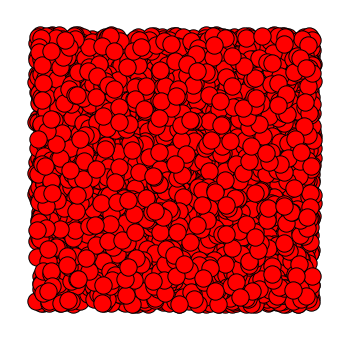

In [176]:
fig = plt.figure(figsize = (6,6))

pos = nx.random_layout(fb)
nx.draw_networkx(fb, pos, with_labels = False, node_color='red', edgecolors='black')
plt.axis('off') 
plt.savefig('files/ch08/facebook_Random.png', dpi = 300, bbox_inches = 'tight')

We can try to draw the graph using default options.

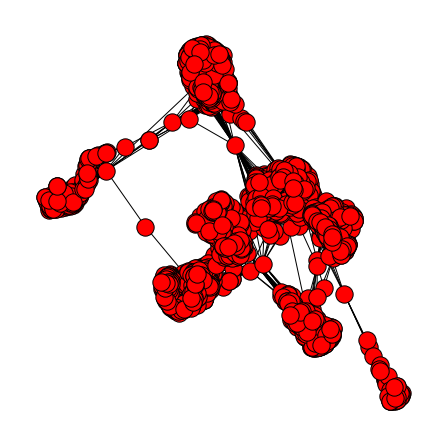

In [177]:
fig = plt.figure(figsize = (6,6))
nx.draw(fb, node_color='red', edgecolors='black')
plt.savefig('files/ch08/facebook_Default.png', dpi = 300, bbox_inches = 'tight')

Let us try to define better ways to shape the graph and also to fine tune the parameters.
We draw centrality measures on the whole Facebook Network.
For that, we compute the position of the nodes using Spring Layout and then we draw the four measures of Centrality.

The function nx.spring_layout returns the position of the nodes using the Fruchterman–Reingold force-directed algorithm.
This algorithm distributes the graph nodes in such a way that all the edges are more or less equally long and they cross themselves as few times as possible. Moreover, we can change the size of the nodes to that defined by their degree centrality. 

In [179]:
pos_fb = nx.spring_layout(fb, iterations = 1000)

In [180]:
np.save('file_pos_fb.npy', pos_fb)

In [189]:
#pos_fb = np.load('file_pos_fb.npy', allow_pickle=True).item()

In the next code, the degree centrality is normalized to values between 0 and 1, and multiplied by a constant to make the sizes appropriate for the format of the figure.

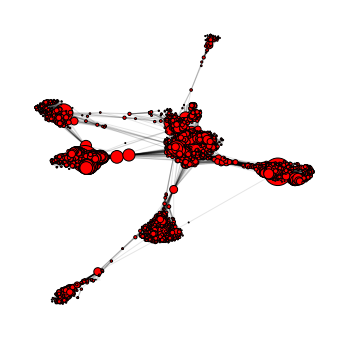

In [219]:
fig = plt.figure(figsize = (6,6))

# Degree centrality:
nsize = np.array([v for v in degree_cent_fb.values()])
cte = 1000
nsize = cte*(nsize  - min(nsize))/(max(nsize)-min(nsize))

nodes = nx.draw_networkx_nodes(fb, pos = pos_fb, node_size = nsize, node_color='red', edgecolors='black')
edges = nx.draw_networkx_edges(fb, pos = pos_fb, alpha = .1)
plt.axis('off') 

plt.savefig('files/ch08/facebook_Degree.png', dpi = 300, bbox_inches = 'tight')

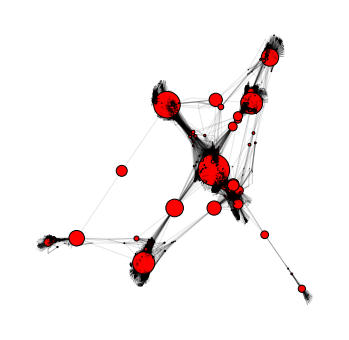

In [182]:
fig = plt.figure(figsize=(6,6))

# Betweenness Centrality
nsize = np.array([v for v in betweenness_fb.values()])
nsize = cte*(nsize  - min(nsize))/(max(nsize)-min(nsize))

nodes = nx.draw_networkx_nodes(fb, pos = pos_fb, node_size = nsize,node_color='red', edgecolors='black')
edges = nx.draw_networkx_edges(fb, pos = pos_fb, alpha = .1)
plt.axis('off') 

plt.savefig('files/ch08/facebook_Betweenness.png', dpi = 300, bbox_inches = 'tight')

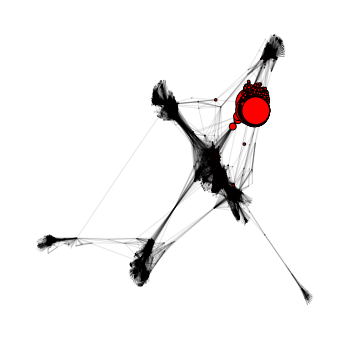

In [187]:
fig = plt.figure(figsize=(6,6))

# Eigenvector Centrality
nsize = np.array([v for v in eigencentrality_fb.values()])
nsize = cte*(nsize  - min(nsize))/(max(nsize) - min(nsize))

nodes = nx.draw_networkx_nodes(fb, pos = pos_fb, node_size = nsize,node_color='red', edgecolors='black')
edges = nx.draw_networkx_edges(fb, pos = pos_fb, alpha = .1)
plt.axis('off') 

plt.savefig('files/ch08/facebook_Eigenvector.png', dpi = 300, bbox_inches = 'tight')

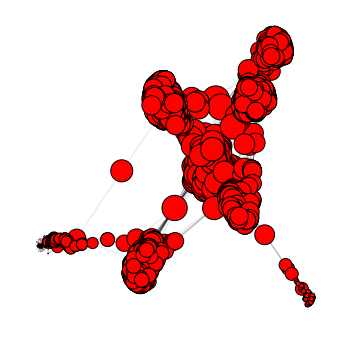

In [184]:
fig = plt.figure(figsize=(6,6))

# Closeness Centrality
nsize = np.array([v for v in closeness_fb.values()])
nsize = cte*(nsize  - min(nsize))/(max(nsize) - min(nsize))

nodes = nx.draw_networkx_nodes(fb, pos = pos_fb, node_size = nsize,node_color='red', edgecolors='black')
edges = nx.draw_networkx_edges(fb, pos = pos_fb, alpha = .1)
plt.axis('off') 

plt.savefig('files/ch08/facebook_Closeness.png', dpi = 300, bbox_inches = 'tight')


These graph visualizations allow us to understand the network better.
Now we can distinguish several groups of nodes or "communities" more clearly in the graph.
Moreover, the more central nodes are the larger more prominent nodes, which are highly connected.

Generally different centrality metrics will be positively correlated, but when they are not, there is probably something interesting about the network nodes.
For instance, if you can spot nodes with high betweenness but relatively low degree, these are the nodes with few links but which are  crucial for network flow.
We can also look for the opposite effect: nodes with high degree but relatively low betweenness. These nodes are those with redundant communication.


### Pagerank
Pagerank is an algorithm related to the concept of eigenvector centrality in directed graphs. It is used to rate webpages objectively and effectively measure the attention devoted to them.
Pagerank was invented by Larry Page and Sergey Brin, and became a Google trademark in 1998.
Assigning the importance of a webpage is a subjective task, which depends on the
interests and knowledge of the browsers.
However, there are ways to objectively rank the relative importance of webpages.
Intuitively, a page has a high rank if the sum of the ranks of its incoming edges is high. This considers both cases when a page has many incoming links and when a page has a few highly ranked incoming links.
Nowadays, a variant of the algorithm is used by Google. It does not only use information on the number of links pointing into and out of a website, but uses many more variables.

Let us compute the Pagerank vector of the Facebook network and use it to define the size of the nodes, as was done above.
The code below outputs the graph that emphasizes some of the nodes with high Pagerank:

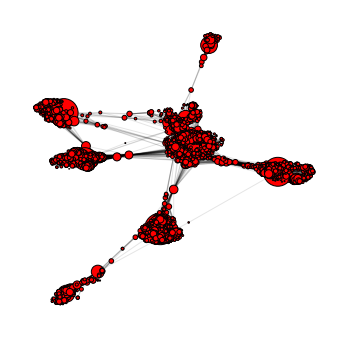

In [220]:
fig = plt.figure(figsize = (6,6))

# Pagerank 
pr=nx.pagerank(fb, alpha = 0.85)
nsize=np.array([v for v in pr.values()])
nsize = cte*(nsize  - min(nsize))/(max(nsize) - min(nsize))

nodes = nx.draw_networkx_nodes(fb, pos = pos_fb, node_size = nsize, node_color='red', edgecolors='black')
edges = nx.draw_networkx_edges(fb, pos = pos_fb, alpha = .1)
plt.axis('off') 

plt.savefig('files/ch08/facebook_pagerank.png', dpi = 300, bbox_inches = 'tight')

## Ego-networks of the Facebook Network

Ego-networks are subnetworks of neighbors that are centered on a certain node. In Facebook and LinkedIn, these are described as \emph{your network}. Every person in an ego-network has her/his own ego-network and can only access the nodes in it. All ego-networks interlock to form the whole social network.
The ego-network definition depends on the network distance considered. In the basic case, a link means that person A is a friends of person B, a distance of 2 means that a person, C, is a friend of a friend of A, and a distance of 3 means that another person, D, is a friend of a friend of a friend of A.
Knowing the size of an ego-network is important when it comes to understanding the reach of the information that a person can transmit or have access to.

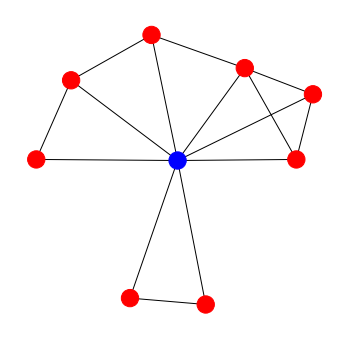

In [228]:
fig = plt.figure(figsize=(6,6))

# Example of ego network:
G = nx.Graph()
G.add_edge('A', 'C');
G.add_edge('A', 'B');
G.add_edge('A', 'D');
G.add_edge('A', 'E');
G.add_edge('A', 'F');
G.add_edge('A', 'G');
G.add_edge('A', 'H');
G.add_edge('A', 'I');
G.add_edge('D', 'C');
G.add_edge('E', 'F');
G.add_edge('G', 'H');
G.add_edge('G', 'I');
G.add_edge('H', 'C');
G.add_edge('H', 'D');
G.add_edge('B', 'I');
c=['b', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r']
nx.draw_networkx(G,  with_labels = False, node_color = c)
plt.axis('off') 
plt.savefig("files/ch08/ego_graph.png")

Our Facebook network is divided into a set of 10 ego-networks which are interconnected to form the fully connected graph we have been analyzing in previous sections.
The dataset includes the information of these 10 manually defined ego-networks. In particular, we have available the list of the 10 ego nodes: '0', '107', '348', '414', '686', '1684', '1912', '3437', '3980' and their connections.
Above we saw that node '107' is the most central node for three of the four centrality measures computed. So, let us extract the ego-networks of the popular node '107' with a distance of 1 and 2, and compute their sizes. NetworkX has a function devoted to this task:

In [229]:
# Automatically compute ego-network
ego_107 = nx.ego_graph(fb, '107')
print('# nodes of the ego graph 107:', len(ego_107))
print('# nodes of the ego graph 107 with radius up to 2:', len(nx.ego_graph(fb, '107', radius = 2)))

# nodes of the ego graph 107: 1046
# nodes of the ego graph 107 with radius up to 2: 2687


Since the Facebook dataset also provides the manually labeled ego-networks, we can compute the actual size of the ego-networks.
We can access to the ego-networks by simply importing *os.path* and reading the edge list corresponding as it is done in the next code.

In [193]:
import os.path

In [194]:
ego_id = '107'
G_107 = nx.read_edgelist(os.path.join('files/ch08/facebook','{0}.edges'.format(ego_id)), nodetype = int)    
print('Nodes of the ego graph 107: ', len(G_107))

Nodes of the ego graph 107:  1034


As can be seen, the size of the manually defined ego-network of node '107' is slightly different from the ego-network automatically computed using NetworX. This is due to the fact that the manual definition is not necessarily referred to the subgraph of neighbors centered on a node.

Let's compare the ego-networks by answering the following questions:
- Which is the most densely connected ego-network?
- Which is the largest (# nodes) ego-network? 
- Is there intersection between ego-networks in the Facebook network?

#### Which is the most densely connected ego-network?

To do that, we compute the number of edges in every ego-network and select the network with the maximum number:

In [195]:
ego_ids = (0, 107, 348, 414, 686, 698, 1684, 1912, 3437, 3980)
ego_sizes = np.zeros((10,1))

# Fill the 'ego_sizes' vector with the size (# edges) of the 10 ego-networks in egoids:
i=0
for id in ego_ids :
    G = nx.read_edgelist(os.path.join('files/ch08/facebook','{0}.edges'.format(id)), nodetype = int)    
    ego_sizes[i] = G.size()      
    print('size of the ego-network ', id,  ego_sizes[i])
    i +=1

size of the ego-network  0 [2519.]
size of the ego-network  107 [26749.]
size of the ego-network  348 [3192.]
size of the ego-network  414 [1693.]
size of the ego-network  686 [1656.]
size of the ego-network  698 [270.]
size of the ego-network  1684 [14024.]
size of the ego-network  1912 [30025.]
size of the ego-network  3437 [4813.]
size of the ego-network  3980 [146.]


In [243]:
[i_max, j] = (ego_sizes == ego_sizes.max()).nonzero()
ego_max = ego_ids[i_max[0]]
print('The most densely connected ego-network is the one of ego:', ego_max)


The most densely connected ego-network is the one of ego: 107


In [200]:
# Load the ego network of node 1912
G = nx.read_edgelist(os.path.join('files/ch08/facebook','{0}.edges'.format(ego_max)), nodetype = int)
G_n = G.order()
G_k = G.size()
G_avg_deg = G_k / G_n
print('Nodes: ', G_n)
print('Edges: ', G_k)
print('Average degree: ', G_avg_deg)

Nodes:  747
Edges:  30025
Average degree:  40.194109772423026


The most densely connected ego-network is that of node '1912', which has an average degree of 40.

#### Which is the largest (# nodes) ego-network?

In [201]:
ego_sizes = np.zeros((10,1))
i = 0
# Fill the 'egosizes' vector with the size (# nodes) of the 10 ego-networks in egoids:
for id in ego_ids :
    G = nx.read_edgelist(os.path.join('files/ch08/facebook','{0}.edges'.format(id)), nodetype = int)    
    ego_sizes[i] = G.order()      
    print('size of the ego-network ', id,  ego_sizes[i])
    i += 1

size of the ego-network  0 [333.]
size of the ego-network  107 [1034.]
size of the ego-network  348 [224.]
size of the ego-network  414 [150.]
size of the ego-network  686 [168.]
size of the ego-network  698 [61.]
size of the ego-network  1684 [786.]
size of the ego-network  1912 [747.]
size of the ego-network  3437 [534.]
size of the ego-network  3980 [52.]


In [244]:
[i_max, j] = (ego_sizes == ego_sizes.max()).nonzero()
ego_max = ego_ids[i_max[0]]
print('The largest ego-network is the one of ego: ', ego_max)

The largest ego-network is the one of ego:  107


In [204]:
G = nx.read_edgelist(os.path.join('files/ch08/facebook','{0}.edges'.format(ego_max)), nodetype = int)
G_n = G.order()
G_k = G.size()
G_avg_deg = G_k / G_n
print('Nodes: ', G_n)
print('Edges: ', G_k)
print('Average degree: ', G_avg_deg)

Nodes:  1034
Edges:  26749
Average degree:  25.86943907156673


#### Is there intersection between ego-networks in the Facebook network?

In [206]:
# Add a field 'egonet' to the nodes of the whole facebook network. 
# Default value egonet=[], meaning that this node does not belong to any ego-netowrk
for i in fb.nodes() :
    fb.nodes[str(i)]['egonet'] = []
    

In [208]:
# Fill the 'egonet' field with one of the 10 ego values in ego_ids:
for id in ego_ids :
    G = nx.read_edgelist(os.path.join('files/ch08/facebook','{0}.edges'.format(id)), nodetype = int)
    print(id)
    for n in G.nodes() :
        if (fb.nodes[str(n)]['egonet'] == []) :
            fb.nodes[str(n)]['egonet'] = [id]
        else :
            fb.nodes[str(n)]['egonet'].append(id)

0
107
348
414
686
698
1684
1912
3437
3980


In [210]:
# Compute the intersections:
S = [len(x['egonet']) for x in fb.nodes.values()]

In [212]:
print('# nodes belonging to 0 ego-network: ', sum(np.equal(S,0)))
print('# nodes belonging to 1 ego-network: ', sum(np.equal(S,1)))
print('# nodes belonging to 2 ego-network: ', sum(np.equal(S,2)))
print('# nodes belonging to 3 ego-network: ', sum(np.equal(S,3)))
print('# nodes belonging to 4 ego-network: ', sum(np.equal(S,4)))
print('# nodes belonging to more than 4 ego-network: ', sum(np.greater(S,4)))

# nodes belonging to 0 ego-network:  80
# nodes belonging to 1 ego-network:  3844
# nodes belonging to 2 ego-network:  102
# nodes belonging to 3 ego-network:  11
# nodes belonging to 4 ego-network:  2
# nodes belonging to more than 4 ego-network:  0


As can be seen, there is intersection between the ego-networks in the Facebook network, since some of the nodes belongs to more than 1 and up to 4 ego-networks simultaneously.


#### More drawings:
Let's draw the ego-networks with different colors on the whole facebook network:

In [215]:
# Add a field 'egocolor' to the nodes of the whole facebook network. 
# Default value egocolor=0, meaning that this node does not belong to any ego-netowrk

for i in fb.nodes() :
    fb.nodes[str(i)]['egocolor'] = 0
    
# Fill the 'egocolor' field with a different color number for each ego-network in ego_ids:
id_color = 1
for id in ego_ids :
    G = nx.read_edgelist(os.path.join('files/ch08/facebook','{0}.edges'.format(id)), nodetype = int)
    for n in G.nodes() :
        fb.nodes[str(n)]['egocolor'] = id_color
    id_color += 1 

In [216]:
colors = [ x['egocolor'] for x in fb.nodes.values()]

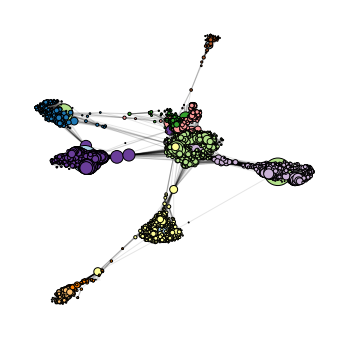

In [221]:
fig = plt.figure(figsize = (6,6))

nsize = np.array([v for v in degree_cent_fb.values()])
nsize = cte*(nsize  - min(nsize))/(max(nsize) - min(nsize))

nodes = nx.draw_networkx_nodes(fb, pos = pos_fb, cmap = plt.get_cmap('Paired'), node_color=colors, node_size = nsize, edgecolors='black')
edges = nx.draw_networkx_edges(fb, pos = pos_fb, alpha = .1)
plt.axis('off') 

plt.savefig('files/ch08/facebook_Colors.png', dpi = 300, bbox_inches = 'tight')

## Community detection

Let's compute communities automaticaly and plot them with different colors on the whole facebook network.
Before import the toolbox download and install in following the instructions in the link:
https://pypi.python.org/pypi/python-louvain/0.3



In [222]:
import community
partition = community.best_partition(fb)

In [223]:
print('# found communities:', max(partition.values()))

# found communities: 15


In [224]:
colors2 = [partition.get(node) for node in fb.nodes()]

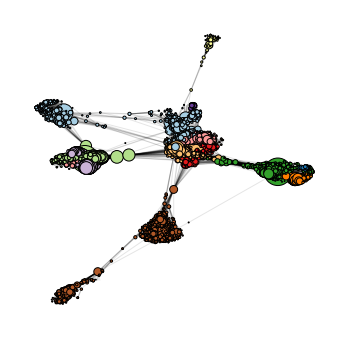

In [226]:
fig = plt.figure(figsize = (6,6))

nsize = np.array([v for v in degree_cent_fb.values()])
nsize = cte*(nsize  - min(nsize))/(max(nsize) - min(nsize))

nodes = nx.draw_networkx_nodes(fb, pos = pos_fb, cmap = plt.get_cmap('Paired'), node_color=colors2, 
                                node_size = nsize, edgecolors='black')
edges = nx.draw_networkx_edges(fb, pos = pos_fb, alpha = .1)
plt.axis('off') 

plt.savefig('files/ch08/facebook_AutoPartition.png', dpi = 300, bbox_inches = 'tight')

As can be seen, the 15 communities found automatically are similar to the 10 ego-networks loaded from the dataset. However, some of the 10 ego-networks are subdivided into several communities now.
This discrepancy is due to the fact that the ego-networks are manually annotated based on more properties of the nodes, whereas communities are extracted based only on the graph information.